In [66]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

train = pd.read_csv('malicious.csv')
train = train[train["APP_PACKETS"] > 0].dropna(axis=0)._get_numeric_data()
target = "Type"
IDcol = "ID"

def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]

    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

[0]	train-auc:0.940831+0.0126853	test-auc:0.916298+0.0237295
[1]	train-auc:0.948787+0.009181	test-auc:0.924609+0.0288359
[2]	train-auc:0.967943+0.0119142	test-auc:0.933768+0.019994
[3]	train-auc:0.970781+0.0119436	test-auc:0.930675+0.0250964
[4]	train-auc:0.97509+0.0116353	test-auc:0.933329+0.0201197
[5]	train-auc:0.97633+0.0116021	test-auc:0.936072+0.0230196
[6]	train-auc:0.978862+0.0106699	test-auc:0.936557+0.0246057
[7]	train-auc:0.980558+0.0107395	test-auc:0.936587+0.024327
[8]	train-auc:0.980538+0.0106033	test-auc:0.935862+0.0250247
[9]	train-auc:0.981055+0.0102641	test-auc:0.939051+0.0248025
[10]	train-auc:0.980759+0.0102607	test-auc:0.942207+0.0191481
[11]	train-auc:0.984229+0.00543575	test-auc:0.942298+0.0231565
[12]	train-auc:0.984811+0.00514507	test-auc:0.940331+0.0222209
[13]	train-auc:0.985248+0.00488731	test-auc:0.947664+0.0151322
[14]	train-auc:0.986354+0.00548312	test-auc:0.948154+0.015436
[15]	train-auc:0.987646+0.00429199	test-auc:0.947428+0.0151984
[16]	train-auc:0.98

[147]	train-auc:1+0	test-auc:0.958013+0.0137066
[148]	train-auc:1+0	test-auc:0.958291+0.0137086
[149]	train-auc:1+0	test-auc:0.958559+0.0137747
[150]	train-auc:1+0	test-auc:0.958644+0.0136433
[151]	train-auc:1+0	test-auc:0.958729+0.0138848
[152]	train-auc:1+0	test-auc:0.957984+0.0138508
[153]	train-auc:1+0	test-auc:0.957912+0.0139538

Model Report
Accuracy : 0.9984
AUC Score (Train): 1.000000


/Users/Matthew/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


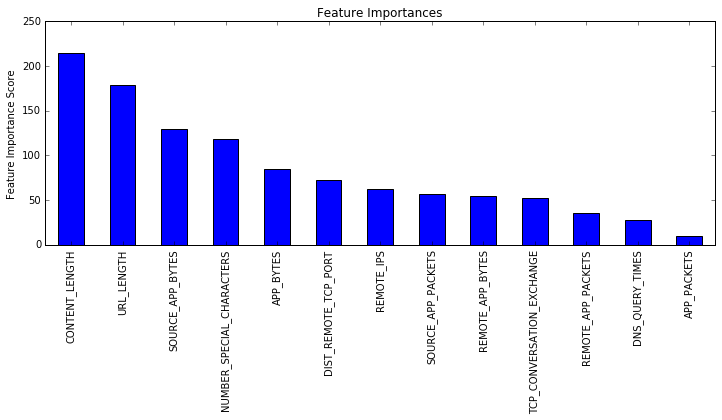

In [68]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)
modelfit(xgb1, train, predictors)
